In [ ]:
# 🔧 Стандартные библиотеки Python
import os
import json

# 📊 Работа с таблицами и массивами
import numpy as np
import pandas as pd

# 🧠 PyTorch
import torch
import torch.nn as nn

# 📈 Визуализация
import matplotlib.pyplot as plt

# 📏 Метрики качества
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


In [30]:
# ========================
# Load holdout data
# ========================
holdout_path = "/mnt/d/projects/wind_pressure_prediction_CNN/data/holdout/windloading_interference_holdout.csv"
holdout_df = pd.read_csv(holdout_path)

# ========================
# Define grid resolution
# ========================
Nx, Ny = 28, 9

# Convert coordinates to indices
holdout_df["X_idx"] = holdout_df["X_fac"].astype(int) - 1
holdout_df["Y_idx"] = holdout_df["Y_fac"].astype(int) - 1

# ========================
# Interpolation function (same as training)
# ========================
def fill_missing_with_interpolation(grid):
    grid_filled = grid.copy()
    Ny, Nx = grid.shape
    facade_ranges = [(0, 6), (7, 13), (14, 20), (21, 27)]
    for y in range(Ny):
        for start, end in facade_ranges:
            for x in range(start, end + 1):
                if np.isnan(grid_filled[y, x]):
                    left = right = None
                    for lx in range(x - 1, start - 1, -1):
                        if not np.isnan(grid_filled[y, lx]):
                            left = grid_filled[y, lx]
                            break
                    for rx in range(x + 1, end + 1):
                        if not np.isnan(grid_filled[y, rx]):
                            right = grid_filled[y, rx]
                            break
                    if left is not None and right is not None:
                        grid_filled[y, x] = (left + right) / 2
                    elif left is not None:
                        grid_filled[y, x] = left
                    elif right is not None:
                        grid_filled[y, x] = right
                    else:
                        grid_filled[y, x] = 0.0
    return grid_filled

# ========================
# Group and build CNN inputs
# ========================
group_cols = ['X_int', 'Y_int', 'Ang']  # ⚠️ Убедись, что в holdout так называются
groups = holdout_df.groupby(group_cols)

X_list = []
Y_list = []
interpolation_log = []

for group_key, group_data in groups:
    grid = np.full((Ny, Nx), np.nan)
    for _, row in group_data.iterrows():
        x, y = int(row["X_idx"]), int(row["Y_idx"])
        grid[y, x] = row["Mean"]  # Целевое значение

    missing_mask = np.isnan(grid)
    interpolated_indices = list(zip(*np.where(missing_mask)))

    for (y, x) in interpolated_indices:
        interpolation_log.append({
            "X_int": group_key[0],
            "Y_int": group_key[1],
            "Ang": group_key[2],
            "X_idx": x,
            "Y_idx": y
        })

    igrid = fill_missing_with_interpolation(grid)

    X_int, Y_int, angle = group_key
    X_grid = np.full((Ny, Nx), X_int)
    Y_grid = np.full((Ny, Nx), Y_int)
    A_grid = np.full((Ny, Nx), angle)

    X_tensor = np.stack([X_grid, Y_grid, A_grid], axis=0)  # (3, 9, 28)
    Y_tensor = igrid[np.newaxis, :, :]                     # (1, 9, 28)

    X_list.append(X_tensor)
    Y_list.append(Y_tensor)

# ========================
# Save holdout CNN data
# ========================
save_dir = "/mnt/d/projects/wind_pressure_prediction_CNN/data/holdout/cnn_holdout"
os.makedirs(save_dir, exist_ok=True)

if interpolation_log:
    log_df = pd.DataFrame(interpolation_log)
    log_df.to_csv(os.path.join(save_dir, "interpolation_log.csv"), index=False)

X_holdout = np.array(X_list)
Y_holdout = np.array(Y_list)

np.save(os.path.join(save_dir, "X_holdout.npy"), X_holdout)
np.save(os.path.join(save_dir, "Y_holdout.npy"), Y_holdout)

with open(os.path.join(save_dir, "grid_info.json"), "w") as f:
    json.dump({"Nx": Nx, "Ny": Ny, "description": "Holdout set for CNN testing"}, f, indent=4)

print("✅ Holdout CNN data saved.")
print(f"📐 X shape: {X_holdout.shape}")
print(f"📐 Y shape: {Y_holdout.shape}")


✅ Holdout CNN data saved.
📐 X shape: (608, 3, 9, 28)
📐 Y shape: (608, 1, 9, 28)


/tmp/ipykernel_71384/783480762.py:33: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_pressure_prediction_CNN/environment/linux_wpp_cnn/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


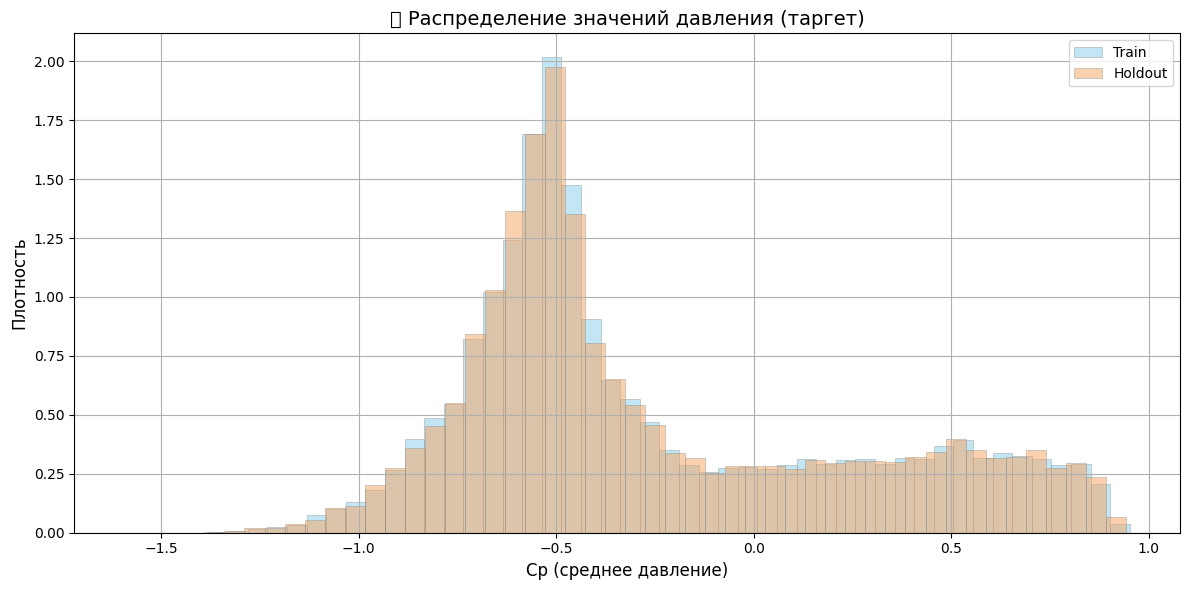

📊 Сравнительная таблица описательной статистики:

               Train       Holdout
count  121113.000000  30279.000000
mean       -0.258191     -0.256064
std         0.497945      0.497211
min        -1.529182     -1.593751
25%        -0.597652     -0.596452
50%        -0.455957     -0.452401
75%         0.105276      0.101199
max         0.952414      0.942534


In [31]:
train_path = "/mnt/d/projects/wind_pressure_prediction_CNN/data/processed/windloading_interference_train.csv"
train_df = pd.read_csv(train_path)

# Определяем название колонки с таргетом
target_col_train = "Mean"
target_col_holdout = "Mean"

import matplotlib.pyplot as plt

# Вычисляем статистику
train_median = train_df[target_col_train].median()
holdout_median = holdout_df[target_col_holdout].median()

train_q1 = train_df[target_col_train].quantile(0.25)
train_q3 = train_df[target_col_train].quantile(0.75)
holdout_q1 = holdout_df[target_col_holdout].quantile(0.25)
holdout_q3 = holdout_df[target_col_holdout].quantile(0.75)

# Рисуем
plt.figure(figsize=(12, 6))
plt.hist(train_df[target_col_train], bins=50, alpha=0.5, label="Train", density=True,
         color='skyblue', edgecolor='gray', linewidth=0.5)
plt.hist(holdout_df[target_col_holdout], bins=50, alpha=0.5, label="Holdout", density=True,
         color='sandybrown', edgecolor='gray', linewidth=0.5)


# Подписи
plt.title("📉 Распределение значений давления (таргет)", fontsize=14)
plt.xlabel("Cp (среднее давление)", fontsize=12)
plt.ylabel("Плотность", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Название колонки с таргетом
target_col_train = "Mean"
target_col_holdout = "Mean"

# Получаем описательную статистику
train_stats = train_df[target_col_train].describe()
holdout_stats = holdout_df[target_col_holdout].describe()

# Объединяем в одну таблицу
summary_df = pd.DataFrame({
    "Train": train_stats,
    "Holdout": holdout_stats
})

# Вывод
print("📊 Сравнительная таблица описательной статистики:\n")
print(summary_df)


In [32]:
# ➤ Класс CNN-модели
class WindPressureCNN(nn.Module):
    def __init__(self, input_channels, filters, activation_fn, use_batchnorm):
        super(WindPressureCNN, self).__init__()

        layers = []
        in_channels = input_channels
        for out_channels in filters:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            if use_batchnorm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(activation_fn())
            in_channels = out_channels

        self.encoder = nn.Sequential(*layers)

        self.decoder = nn.Sequential(
            nn.Conv2d(filters[-1], filters[-2], kernel_size=3, padding=1),
            activation_fn(),
            nn.Conv2d(filters[-2], 1, kernel_size=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [33]:
# ➤ Класс CNN-модели (предполагаем, что он уже определён выше)
# class WindPressureCNN(nn.Module): ...

# 📍 Укажи путь к конфигу и весам
CONFIG_PATH = "/mnt/d/projects/wind_pressure_prediction_CNN/final_models/cnn_2e-04lr_64bs_ELU_16f/cnn_2e-04lr_64bs_ELU_16f.json"
MODEL_SAVE_PATH = "/mnt/d/projects/wind_pressure_prediction_CNN/final_models/cnn_2e-04lr_64bs_ELU_16f/best_input_seed882593_ELU_Adam.pth"

# ➤ Загружаем конфиг
with open(CONFIG_PATH, "r") as f:
    config = json.load(f)

# ➤ Преобразуем имя функции активации в класс
activation_map = {
    "ReLU": nn.ReLU,
    "Tanh": nn.Tanh,
    "Sigmoid": nn.Sigmoid,
    "LeakyReLU": nn.LeakyReLU,
    "ELU": nn.ELU,
    "SELU": nn.SELU,
    "GELU": nn.GELU
}


activation_fn = activation_map[config["activation_fn"]]

# ➤ Воссоздаём модель
model = WindPressureCNN(
    input_channels=config["input_channels"],
    filters=config["filters"],
    activation_fn=activation_fn,
    use_batchnorm=config["batchnorm"]
)

# ✅ ЗАГРУЖАЕМ ВЕСА НА CPU
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=torch.device('cpu')))
model.eval()  # переводим в режим оценки

print("✅ Модель успешно восстановлена и готова к использованию.")


✅ Модель успешно восстановлена и готова к использованию.


In [ ]:
# 📥 Загрузка holdout-гридов
X_holdout = np.load("/mnt/d/projects/wind_pressure_prediction_CNN/data/processed/cnn_input/X_cnn.npy")

# 🔮 Предсказание
model.eval()
with torch.no_grad():
    X_tensor = torch.tensor(X_holdout, dtype=torch.float32)
    y_pred = model(X_tensor).numpy()  # → (N, 1, 9, 28)

# 💾 Сохраняем предсказания
np.save("/mnt/d/projects/wind_pressure_prediction_CNN/final_models/cnn_2e-04lr_64bs_ELU_16f/y_pred.npy", y_pred)

print("✅ Предсказания успешно получены и сохранены.")
print("🧱 Y_pred shape:", y_pred.shape)


✅ Предсказания успешно получены и сохранены.
🧱 Y_pred shape: (608, 1, 9, 28)


In [ ]:
# 📥 Загрузка holdout.csv и y_pred
df = pd.read_csv(holdout_path)

# Индексация grid'ов по (X_int, Y_int, angle)
# Сопоставим (X_int, Y_int, angle) → индекс в y_pred
X_grouped = df.groupby(['X_int', 'Y_int', 'Ang']).ngroup()
df["grid_index"] = X_grouped

# Проверка — должно быть столько же уникальных групп, сколько в y_pred
assert df["grid_index"].nunique() == y_pred.shape[0], "❌ Число групп не совпадает с размерностью y_pred"

# Индексы внутри грида (нумерация с 1 → уменьшаем на 1)
df["x_idx"] = df["X_fac"].astype(int) - 1
df["y_idx"] = df["Y_fac"].astype(int) - 1

# Извлекаем предсказания
pred_values = []
for _, row in df.iterrows():
    i = row["grid_index"]
    x = int(row["x_idx"])
    y = int(row["y_idx"])
    pred = y_pred[i, 0, y, x]  # y: строка, x: столбец
    pred_values.append(pred)

# Добавляем в DataFrame
df["Mean_pred"] = pred_values

# 💾 Сохраняем результат
output_csv = "/mnt/d/projects/wind_pressure_prediction_CNN/final_models/cnn_2e-04lr_64bs_ELU_16f/holdout_with_preds.csv"
df.to_csv(output_csv, index=False)

print(f"✅ Предсказания добавлены к точкам и сохранены в:\n{output_csv}")


✅ Предсказания добавлены к точкам и сохранены в:
/mnt/d/projects/wind_pressure_prediction_CNN/final_models/cnn_2e-04lr_64bs_ELU_16f/holdout_with_preds.csv


🔢 Количество сравниваемых точек: 30279
📈 Holdout Evaluation (по точкам):
   R²   = 0.9851
   MAE  = 0.0418
   MSE  = 0.003671


/tmp/ipykernel_71384/2997000060.py:45: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_71384/2997000060.py:45: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_pressure_prediction_CNN/environment/linux_wpp_cnn/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/mnt/d/projects/wind_pressure_prediction_CNN/environment/linux_wpp_cnn/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


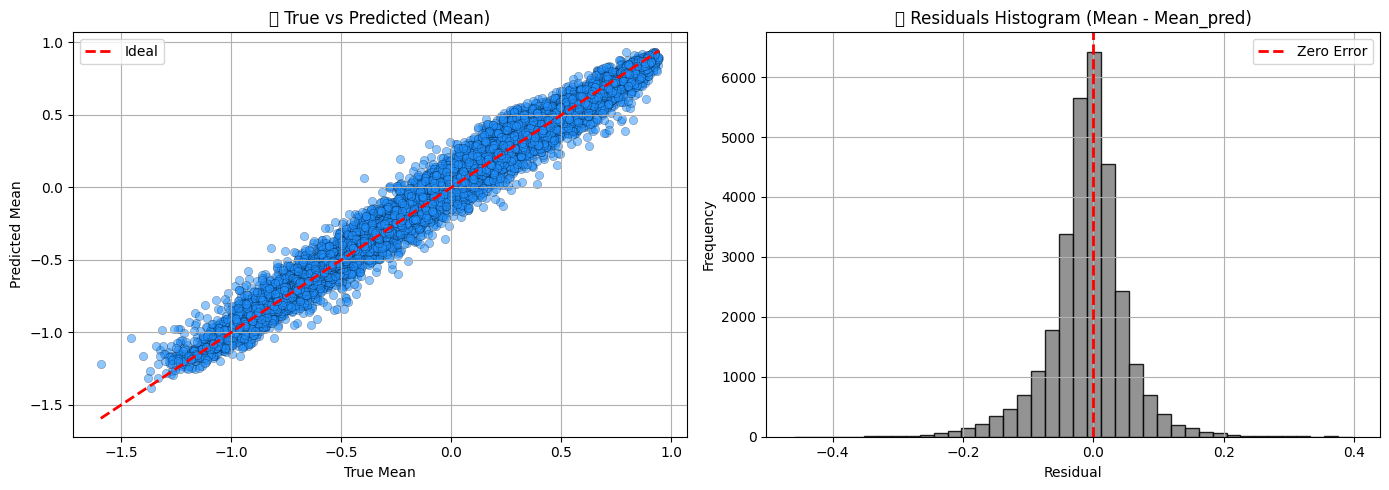

In [ ]:
y_true = df["Mean"].values
y_pred = df["Mean_pred"].values

# 📊 Метрики
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)


num_points = len(y_true)
print(f"🔢 Количество сравниваемых точек: {num_points}")

print("📈 Holdout Evaluation (по точкам):")
print(f"   R²   = {r2:.4f}")
print(f"   MAE  = {mae:.4f}")
print(f"   MSE  = {mse:.6f}")

# 📉 Остатки
residuals = y_true - y_pred

# 📊 Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 🎯 True vs Predicted
axes[0].scatter(y_true, y_pred, alpha=0.5, color="dodgerblue", edgecolors='k', linewidths=0.3)
axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label="Ideal")
axes[0].set_xlabel("True Mean")
axes[0].set_ylabel("Predicted Mean")
axes[0].set_title("🎯 True vs Predicted (Mean)")
axes[0].grid(True)
axes[0].legend()

# 📊 Residuals Histogram
axes[1].hist(residuals, bins=40, color='gray', edgecolor='black', alpha=0.85)
axes[1].axvline(x=0, color='red', linestyle='--', lw=2, label="Zero Error")
axes[1].set_xlabel("Residual")
axes[1].set_ylabel("Frequency")
axes[1].set_title("📊 Residuals Histogram (Mean - Mean_pred)")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()
